In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier
from lifelines.utils import median_survival_times
from dtreeviz.trees import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import KFold

In [3]:
brain_mets = pd.read_excel('./data/BrainMets_List_July2020_LF_OS.xlsx')
brain_mets['Patients'] = brain_mets['PiCare MetID'].str.slice(15,20)

### EDA

In [110]:
## Columns

In [111]:
len(brain_mets.columns)

56

In [112]:
## Rows

In [113]:
len(brain_mets)

10445

In [114]:
brain_mets['Sex'].value_counts()

F    6544
M    3837
0      64
Name: Sex, dtype: int64

In [115]:
brain_mets['Primary tumor Site'].value_counts()

Lung        3716
Breast      3030
Melanoma    2194
Kidney       521
GI           306
Other        241
GYN          194
Sarcoma      125
Unknown      102
Name: Primary tumor Site, dtype: int64

In [116]:
brain_mets.columns

Index(['PiCare MetID', 'Failure-binary', 'Failure-eventFreeTime',
       'Follow-up time', 'Time to death', 'Date GK', 'Age', 'Sex', 'Race',
       'Primary tumor Site', 'Primary tumor Histology', 'ECM', 'Location',
       'Brief location', 'Side', 'Lateral dimension', 'AP dimension',
       'Vertical dimension', '#Metastases at 1st GK',
       'Time between prim and met diagnosis', 'Prior SRS to same lesion',
       'Prior SRS to other lesion', 'KPS at 1st GK', 'GPA', 'RPA', 'ECOG',
       'Prescribed IDL', 'Target vol in IDL', 'IDL volume',
       'Vol in 12 Gy line', 'Vol in 10 Gy line', 'Conformity index',
       'Gradient index', 'Heterogeneity index', 'Prior_EBRT', 'Prior_RS',
       'Prior_Chemo', 'Conc_Chemo', 'Salvage_RS', 'Salv_surg', 'Headaches',
       'Seizures', 'Neuro symptoms', 'Prescription Dose', 'Max Dose',
       'Target volume', 'Target vol in IDL.1', 'Maximum Tumor Diameter',
       'Distance from Ventricle', 'BRAF_status', 'CKIT_status', 'NRAS_status',
       'EF

/Users/anishmukherjee/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

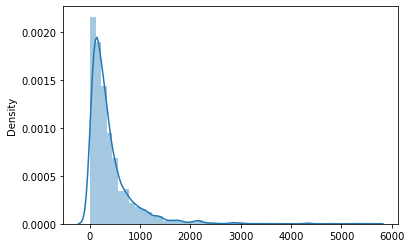

In [117]:
sns.distplot(x = brain_mets['Time to death'])


In [118]:
brain_mets['Follow-up time']

0          205
1          205
2          205
3           48
4           48
         ...  
10440   -42688
10441   -42688
10442   -42919
10443   -42921
10444   -42947
Name: Follow-up time, Length: 10445, dtype: int64

## Demographic Analysis

### Removing duplicates

In [119]:
brain_mets['Patients'] = brain_mets['PiCare MetID'].str.slice(15,20)


In [120]:
pats = brain_mets[['Patients']].drop_duplicates()

In [121]:
brain_mets['Patients'] = brain_mets['PiCare MetID'].str.slice(15,20)
brain_m = brain_mets[['Age','Sex','Patients','Primary tumor Site',
                      'Time to death','KPS at 1st GK','#Metastases at 1st GK','ECM']]
brain_m = brain_m.drop_duplicates()

In [15]:
brain_m.groupby(by = ['Patients']).count()['Age'].value_counts() 

1    1449
2     272
3      91
4      35
5      12
7       3
6       2
8       2
Name: Age, dtype: int64

In [16]:
brain_m.groupby(by = ['Patients']).count()['Primary tumor Site'].value_counts() 

1    1450
2     270
3      93
4      34
5      11
7       3
6       2
8       2
0       1
Name: Primary tumor Site, dtype: int64

In [17]:
brain_m.groupby(by = ['Patients']).count()['KPS at 1st GK'].value_counts() 

1    1387
2     260
3      88
0      78
4      34
5      12
7       3
6       2
8       2
Name: KPS at 1st GK, dtype: int64

In [18]:
brain_m.groupby(by = ['Patients']).count()['ECM'].value_counts() 

1    1449
2     272
3      91
4      35
5      12
7       3
6       2
8       2
Name: ECM, dtype: int64

In [19]:
## Identifying records that have duplicates in age

In [20]:
brain_mets

,PiCare MetID,Failure-binary,Failure-eventFreeTime,Follow-up time,Time to death,Date GK,Age,Sex,Race,Primary tumor Site,...,Maximum Tumor Diameter,Distance from Ventricle,BRAF_status,CKIT_status,NRAS_status,EFGR_status,ALK_status,HER2-amplified status,Distance_from_ventricle,Patients
0,BrainMets-UCSF-00001-001,0,205.0,205,205.0,1999-07-08,51.369863,F,NaN,Lung,...,3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00001
1,BrainMets-UCSF-00001-002,1,165.0,205,205.0,1999-07-08,51.369863,F,NaN,Lung,...,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00001
2,BrainMets-UCSF-00001-003,0,205.0,205,205.0,1999-07-08,51.369863,F,NaN,Lung,...,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00001
3,BrainMets-UCSF-00002-001,0,48.0,48,48.0,2001-03-22,77.591781,F,NaN,Lung,...,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00002
4,BrainMets-UCSF-00002-002,0,48.0,48,48.0,2001-03-22,77.591781,F,NaN,Lung,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10440,BrainMets-UCSF-01875-003,0,NaN,-42688,NaN,2016-11-14,59.852055,M,NaN,Melanoma,...,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01875
10441,BrainMets-UCSF-01875-004,0,NaN,-42688,NaN,2016-11-14,59.852055,M,NaN,Melanoma,...,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01875
10442,BrainMets-UCSF-01909-001,0,NaN,-42919,NaN,2017-07-03,78.271233,M,NaN,Kidney,...,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01909
10443,BrainMets-UCSF-01921-001,0,42.0,-42921,42.0,2017-07-05,69.150685,M,NaN,GI,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01921


In [21]:
dedup = brain_m.groupby(by = ['Patients']).count().reset_index()
dedup_age = dedup[dedup['Age']>1]
dedup_age

,Patients,Age,Sex,Primary tumor Site,Time to death,KPS at 1st GK,#Metastases at 1st GK,ECM
7,00009,2,2,2,2,2,2,2
15,00017,2,2,2,2,2,2,2
18,00020,2,2,2,2,2,2,2
33,00035,3,3,3,3,3,3,3
34,00036,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...
1837,01841,3,3,3,0,0,3,3
1840,01844,2,2,2,0,2,2,2
1842,01846,2,2,2,0,2,2,2
1848,01853,3,3,3,3,3,3,3


In [22]:
brain_mets[brain_mets['Patients'] == '00009']

,PiCare MetID,Failure-binary,Failure-eventFreeTime,Follow-up time,Time to death,Date GK,Age,Sex,Race,Primary tumor Site,...,Maximum Tumor Diameter,Distance from Ventricle,BRAF_status,CKIT_status,NRAS_status,EFGR_status,ALK_status,HER2-amplified status,Distance_from_ventricle,Patients
23,BrainMets-UCSF-00009-001,1,143.0,170,170.0,1996-09-16,48.583562,M,NaN,Melanoma,...,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00009
24,BrainMets-UCSF-00009-002,0,170.0,170,170.0,1996-09-16,48.583562,M,NaN,Melanoma,...,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00009
25,BrainMets-UCSF-00009-003,1,143.0,170,170.0,1996-09-16,48.583562,M,NaN,Melanoma,...,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00009
26,BrainMets-UCSF-00009-004,1,143.0,170,170.0,1996-09-16,48.583562,M,NaN,Melanoma,...,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00009
27,BrainMets-UCSF-00009-005,0,170.0,170,170.0,1996-09-16,48.583562,M,NaN,Melanoma,...,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00009
28,BrainMets-UCSF-00009-006,1,143.0,170,170.0,1996-09-16,48.583562,M,NaN,Melanoma,...,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00009
29,BrainMets-UCSF-00009-007,0,104.0,104,104.0,1996-11-21,48.764384,M,NaN,Melanoma,...,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00009
30,BrainMets-UCSF-00009-008,0,104.0,104,104.0,1996-11-21,48.764384,M,NaN,Melanoma,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00009


In [23]:
dedup_tumor_site = brain_mets[['Patients','Primary tumor Site']].drop_duplicates()

In [24]:
dedup_tumor_site

,Patients,Primary tumor Site
0,00001,Lung
3,00002,Lung
8,00003,Melanoma
12,00004,Melanoma
14,00005,Lung
...,...,...
10437,01874,Lung
10438,01875,Melanoma
10442,01909,Kidney
10443,01921,GI


In [25]:
dedup_tumor_site['Patients'].value_counts()

00734    2
00275    2
01460    2
01478    2
01383    2
        ..
00096    1
01285    1
00382    1
01018    1
01254    1
Name: Patients, Length: 1866, dtype: int64

In [26]:
# Patients with duplicate Tumor site 01383, 00275, 01460

In [27]:
pat_00275 = dedup_tumor_site[dedup_tumor_site['Patients'] == '00275']
pat_00275

,Patients,Primary tumor Site
1073,00275,Kidney
1079,00275,NaN


In [28]:
pat_00275

,Patients,Primary tumor Site
1073,00275,Kidney
1079,00275,NaN


In [29]:
### Patients with duplicate ECM 

In [30]:
dedup_ecm = brain_mets[['Patients','ECM']].drop_duplicates()
dedup_ecm['Patients'].value_counts()


01059    1
00572    1
00255    1
01792    1
01608    1
        ..
01285    1
00382    1
01018    1
00996    1
01254    1
Name: Patients, Length: 1866, dtype: int64

#### No duplicates for ECM

In [31]:
dedup_kps = brain_mets[['Patients','KPS at 1st GK']].drop_duplicates()
dedup_kps['Patients'].value_counts()


01059    1
00572    1
00255    1
01792    1
01608    1
        ..
01285    1
00382    1
01018    1
00996    1
01254    1
Name: Patients, Length: 1866, dtype: int64

In [34]:
### No duplicates for KPS as well

### Summary: Some patients have duplicate age columns and primary soc as na, do we exculde those patients ?

### Solution sort data by patient and date at 1st GK, that should be our unique list of pats 

In [33]:
brain_mets['Patients'] = brain_mets['PiCare MetID'].str.slice(15,20)
brain_m = brain_mets[['Age','Sex','Patients','Primary tumor Site',
                      'Time to death','KPS at 1st GK','#Metastases at 1st GK','ECM','Date GK','Follow-up time']]
brain_m = brain_m.drop_duplicates()

In [34]:
brain_mets

,PiCare MetID,Failure-binary,Failure-eventFreeTime,Follow-up time,Time to death,Date GK,Age,Sex,Race,Primary tumor Site,...,Maximum Tumor Diameter,Distance from Ventricle,BRAF_status,CKIT_status,NRAS_status,EFGR_status,ALK_status,HER2-amplified status,Distance_from_ventricle,Patients
0,BrainMets-UCSF-00001-001,0,205.0,205,205.0,1999-07-08,51.369863,F,NaN,Lung,...,3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00001
1,BrainMets-UCSF-00001-002,1,165.0,205,205.0,1999-07-08,51.369863,F,NaN,Lung,...,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00001
2,BrainMets-UCSF-00001-003,0,205.0,205,205.0,1999-07-08,51.369863,F,NaN,Lung,...,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00001
3,BrainMets-UCSF-00002-001,0,48.0,48,48.0,2001-03-22,77.591781,F,NaN,Lung,...,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00002
4,BrainMets-UCSF-00002-002,0,48.0,48,48.0,2001-03-22,77.591781,F,NaN,Lung,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10440,BrainMets-UCSF-01875-003,0,NaN,-42688,NaN,2016-11-14,59.852055,M,NaN,Melanoma,...,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01875
10441,BrainMets-UCSF-01875-004,0,NaN,-42688,NaN,2016-11-14,59.852055,M,NaN,Melanoma,...,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01875
10442,BrainMets-UCSF-01909-001,0,NaN,-42919,NaN,2017-07-03,78.271233,M,NaN,Kidney,...,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01909
10443,BrainMets-UCSF-01921-001,0,42.0,-42921,42.0,2017-07-05,69.150685,M,NaN,GI,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01921


In [35]:
brain_mets['Follow-up time'].isna().sum()

0

In [36]:
analysis = brain_mets[(brain_mets['Time to death'].notnull()) & (brain_mets['Follow-up time'] > 0)]

In [37]:
analysis = analysis[['Patients','Follow-up time','Time to death']].drop_duplicates()
analysis['diff'] = analysis['Follow-up time'] - analysis['Time to death'] 

### Difference between follow up time and time to death

(array([   2.,    0.,    0.,    0.,    2.,    2.,    4.,   10.,   26.,
        1445.]),
 array([-4863. , -4376.7, -3890.4, -3404.1, -2917.8, -2431.5, -1945.2,
        -1458.9,  -972.6,  -486.3,     0. ]),
 <BarContainer object of 10 artists>)

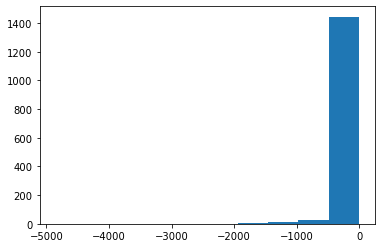

In [38]:
plt.hist(analysis['diff'])

### Taking the first treatment date

In [39]:
brain_m['row_num'] = brain_m.sort_values(['Patients','Date GK'], \
             ascending=[True,True])\
             .groupby(['Patients'])\
             .cumcount() + 1
final_dataset = brain_m[brain_m['row_num'] == 1]

In [40]:
### Excluding null values

In [41]:
final_dataset

,Age,Sex,Patients,Primary tumor Site,Time to death,KPS at 1st GK,#Metastases at 1st GK,ECM,Date GK,Follow-up time,row_num
0,51.369863,F,00001,Lung,205.0,80.0,3.0,False,1999-07-08,205,1
3,77.591781,F,00002,Lung,48.0,60.0,5.0,False,2001-03-22,48,1
8,45.400000,M,00003,Melanoma,189.0,90.0,4.0,True,1994-07-12,189,1
12,51.564384,F,00004,Melanoma,127.0,70.0,2.0,True,1997-06-30,127,1
14,39.726027,M,00005,Lung,NaN,90.0,6.0,True,1999-06-03,19,1
...,...,...,...,...,...,...,...,...,...,...,...
10437,85.098630,F,01874,Lung,NaN,NaN,1.0,0,2016-10-20,-42663,1
10438,59.852055,M,01875,Melanoma,NaN,90.0,4.0,True,2016-11-14,-42688,1
10442,78.271233,M,01909,Kidney,NaN,70.0,1.0,0,2017-07-03,-42919,1
10443,69.150685,M,01921,GI,42.0,NaN,1.0,0,2017-07-05,-42921,1


In [42]:
final_dataset['Time to death'] = np.where((final_dataset['Time to death'].isna()) & (
                                            final_dataset['Follow-up time'] > 0),
                                          final_dataset['Follow-up time'],
                                          final_dataset['Time to death'])

<ipython-input-42-78dcad5e5442>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Time to death'] = np.where((final_dataset['Time to death'].isna()) & (


In [43]:
final_dataset.isna().sum()

Age                        0
Sex                        0
Patients                   0
Primary tumor Site         1
Time to death            287
KPS at 1st GK             78
#Metastases at 1st GK      3
ECM                        0
Date GK                    0
Follow-up time             0
row_num                    0
dtype: int64

#### filtering out null values 

In [44]:
final_dataset = final_dataset[(final_dataset['Time to death'].notnull()) & (final_dataset['KPS at 1st GK'].notnull())
                             &(final_dataset['#Metastases at 1st GK'].notnull())]

In [45]:
final_dataset

,Age,Sex,Patients,Primary tumor Site,Time to death,KPS at 1st GK,#Metastases at 1st GK,ECM,Date GK,Follow-up time,row_num
0,51.369863,F,00001,Lung,205.0,80.0,3.0,False,1999-07-08,205,1
3,77.591781,F,00002,Lung,48.0,60.0,5.0,False,2001-03-22,48,1
8,45.400000,M,00003,Melanoma,189.0,90.0,4.0,True,1994-07-12,189,1
12,51.564384,F,00004,Melanoma,127.0,70.0,2.0,True,1997-06-30,127,1
14,39.726027,M,00005,Lung,19.0,90.0,6.0,True,1999-06-03,19,1
...,...,...,...,...,...,...,...,...,...,...,...
10304,57.676712,F,01839,Lung,16.0,80.0,24.0,True,2016-10-19,-42662,1
10378,62.284932,F,01853,GYN,276.0,90.0,9.0,0,2016-11-28,-42702,1
10396,62.120548,M,01855,Lung,123.0,80.0,3.0,0,2016-12-01,-42705,1
10425,33.701370,F,01863,Breast,185.0,90.0,1.0,0,2016-12-28,-42732,1


In [46]:
final_dataset.describe()

,Age,Time to death,KPS at 1st GK,#Metastases at 1st GK,Follow-up time,row_num
count,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.0
mean,57.576546,564.060052,81.344648,3.869452,-6493.454961,1.0
std,12.494814,812.813094,10.783482,4.109848,15348.323162,0.0
min,7.000000,1.000000,40.000000,1.000000,-42732.000000,1.0
25%,49.412329,139.750000,80.000000,1.000000,25.000000,1.0
50%,58.053425,290.000000,80.000000,3.000000,181.000000,1.0
75%,66.206849,612.250000,90.000000,5.000000,478.500000,1.0
max,97.810959,6517.000000,100.000000,61.000000,6517.000000,1.0


#### Number of patients left is 1402
#### There are patients with 61 mets !

## DS GPA SCORE 

In [47]:
### Age

/Users/anishmukherjee/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


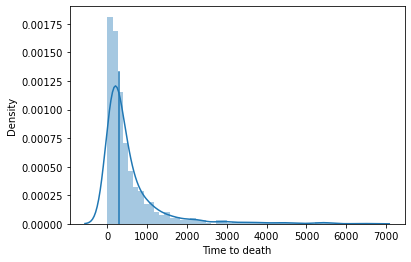

In [48]:
ttd = final_dataset[final_dataset['Time to death'].isna() == False]['Time to death'] 
sns.distplot(ttd)
plt.axvline(np.median(ttd),0,0.7)

In [49]:
## The distribution is right skewed with medain = 275 days

In [50]:
def GPA(df):
    ### LUNG GPA
    df_lung = df[df['Primary tumor Site'] == 'Lung'].copy()
    
    df_lung['Age_GPA'] = np.where(df_lung['Age']>60,0,np.where(df_lung['Age']<50,1,0.5))
    
    df_lung['KPS_GPA'] = np.where(df_lung['KPS at 1st GK'] < 70,0,
                                        np.where(df_lung['KPS at 1st GK']>=90,1,0.5))
    
    df_lung['ECM_GPA'] = np.where(((df_lung['ECM']=='False' ) | (df_lung['ECM']==0)),1,
                                    np.where(df_lung['ECM']=='Unkn',0.5,0))

    df_lung['BM_GPA'] = np.where(df_lung['#Metastases at 1st GK'] >3 ,0,
                                 np.where(df_lung['#Metastases at 1st GK']<=1,1,0.5))

    df_lung['patient_gpa'] = df_lung['Age_GPA'] + df_lung['KPS_GPA'] + df_lung['ECM_GPA'] + df_lung['BM_GPA']

    df_lung.drop(['Age_GPA','KPS_GPA','ECM_GPA','BM_GPA'],inplace = True, axis = 1)
    
    ### Melanoma GPA
    
    df_melanoma = df[df['Primary tumor Site'] == 'Melanoma'].copy()
    
    df_melanoma['KPS_GPA'] = np.where(df_melanoma['KPS at 1st GK'] < 70,0,
                                      np.where(df_melanoma['KPS at 1st GK']>=90,2,1))
    
    df_melanoma['BM_GPA'] = np.where(df_melanoma['#Metastases at 1st GK'] >3 ,0,
                                     np.where(df_melanoma['#Metastases at 1st GK']<=1,2,1))
    
    df_melanoma['patient_gpa'] = df_melanoma['KPS_GPA'] + df_melanoma['BM_GPA']  
                                    
    
    df_melanoma.drop(['KPS_GPA','BM_GPA'],inplace = True, axis = 1)
        
    
    ### Breast GPA
    
    df_breast = df[df['Primary tumor Site'] == 'Breast'].copy()
    
    
    df_breast['KPS_GPA'] = np.where(df_breast['KPS at 1st GK'] < 70, 0,
                                      np.where(df_breast['KPS at 1st GK'] >= 90, 1, 0.5))
    
    
    df_breast['Age_GPA'] = np.where(df_breast['Age'] > 60,0,np.where(df_breast['Age'] < 50, 1, 0.5))
    
    
    df_breast['BM_GPA'] = np.where(df_breast['#Metastases at 1st GK'] >3, 0,
                               np.where(df_breast['#Metastases at 1st GK']<=1, 1, 0.5))
    
    
    df_breast['ECM_GPA'] = np.where(((df_breast['ECM']=='False' ) | (df_breast['ECM']==0)), 1,
                                    np.where(df_breast['ECM']=='Unkn', 0.5, 0))
    
    
    df_breast['patient_gpa'] = df_breast['Age_GPA'] + df_breast['KPS_GPA'] + \
                               df_breast['ECM_GPA'] + df_breast['BM_GPA']
    
    
    df_breast.drop(['KPS_GPA','BM_GPA','Age_GPA','ECM_GPA'],inplace = True, axis = 1)
    
    ### Kidney GPA
    
    df_kidney = df[df['Primary tumor Site'] == 'Kidney'].copy()
    
    df_kidney['KPS_GPA'] = np.where(df_kidney['KPS at 1st GK'] < 70,0,
                                    np.where(df_kidney['KPS at 1st GK']>=90, 2, 1))
    
    df_kidney['BM_GPA'] = np.where(df_kidney['#Metastases at 1st GK'] > 3 ,0,
                                    np.where(df_kidney['#Metastases at 1st GK']<=1, 2, 1))
    
    df_kidney['patient_gpa'] = df_kidney['KPS_GPA'] + df_kidney['BM_GPA']  
    
    
    df_kidney.drop(['KPS_GPA','BM_GPA'],inplace = True, axis = 1)
    
    
    ### GI GPA
    
    df_gi = df[df['Primary tumor Site'] == 'GI'].copy()
    
    df_gi['patient_gpa'] = np.where(df_gi['KPS at 1st GK'] < 70,0,
                                    np.where(df_gi['KPS at 1st GK']== 70, 1,
                                    np.where(df_gi['KPS at 1st GK']== 80, 2,
                                    np.where(df_gi['KPS at 1st GK']== 90, 3, 4))))
    
    ### Other_cancers
    
    df_other = df[~df['Primary tumor Site'].isin(['GI','Kidney','Breast','Melanoma','Lung'])]
    
    df_other['patient_gpa'] = None
    
    df = pd.concat([df_melanoma,df_lung,df_gi,df_kidney,df_breast,df_other])
    
    return df

## Random

In [51]:
final_dataset['Primary tumor Site'].value_counts().sum()

1532

In [52]:
final_dataset_gpa = GPA(final_dataset)

<ipython-input-50-4e7cd007bb25>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_other['patient_gpa'] = None


In [53]:
final_dataset_gpa['Primary tumor Site'].value_counts().sum()

1532

In [54]:
final_dataset_gpa.isna().sum()

Age                        0
Sex                        0
Patients                   0
Primary tumor Site         0
Time to death              0
KPS at 1st GK              0
#Metastases at 1st GK      0
ECM                        0
Date GK                    0
Follow-up time             0
row_num                    0
patient_gpa              125
dtype: int64

In [55]:
final_dataset_gpa['patient_gpa'].value_counts()

2.0    368
3.0    263
1.0    226
1.5    179
2.5    158
4.0     88
0.5     68
3.5     31
0.0     26
Name: patient_gpa, dtype: int64

## Time to death

In [56]:
## Only considering patients that died
final_dataset_gpa[(final_dataset_gpa['Primary tumor Site'] == 'GI') & (final_dataset_gpa['patient_gpa'] == 4)]

,Age,Sex,Patients,Primary tumor Site,Time to death,KPS at 1st GK,#Metastases at 1st GK,ECM,Date GK,Follow-up time,row_num,patient_gpa
1082,76.575342,M,00277,GI,356.0,100.0,1.0,True,1997-12-05,356,1,4


In [57]:
final_dataset_gpa['gpa_range'] = np.where(final_dataset_gpa['patient_gpa'] == None, None,
                                          np.where(final_dataset_gpa['patient_gpa'] <=1, '0-1', 
                                          np.where((final_dataset_gpa['patient_gpa'] >1) & 
                                          (final_dataset_gpa['patient_gpa'] <=2),'1.5-2',
                                          np.where(final_dataset_gpa['patient_gpa'] > 3,'3.5-4','2.5-3.0'))))         

In [58]:
n_sizes = final_dataset_gpa.groupby(by = ['Primary tumor Site','gpa_range']).count().reset_index()
n_sizes = n_sizes[['Primary tumor Site','gpa_range','patient_gpa']]
n_sizes.rename(columns = {'patient_gpa' : 'patient_count'}, inplace = True)

In [59]:
n_sizes

,Primary tumor Site,gpa_range,patient_count
0,Breast,0-1,87
1,Breast,1.5-2,169
2,Breast,2.5-3.0,88
3,Breast,3.5-4,18
4,GI,0-1,14
5,GI,1.5-2,17
6,GI,2.5-3.0,19
7,GI,3.5-4,1
8,GYN,2.5-3.0,0
9,Kidney,0-1,25


### CI Table

In [60]:
final_dataset_gpa['Died'] = np.where(final_dataset_gpa['Time to death']== None, 0, 1)
final_dataset_gpa['Died'] = final_dataset_gpa['Died'].astype(bool)
median_intmed = final_dataset_gpa[['Died','Primary tumor Site','gpa_range','Time to death']]
median_intmed = median_intmed[median_intmed['Primary tumor Site'].isin(['Breast','GI','Kidney','Lung','Melanoma'])]
median_intmed['months'] = median_intmed['Time to death']/30.5

In [5]:
def CI(df):
    total_df = pd.DataFrame()
    for j in df['Primary tumor Site'].unique():
        for i in df[df['Primary tumor Site'] == j]['gpa_range'].unique():
            df_temp = df[(df['gpa_range'] == i) &(df['Primary tumor Site'] == j)]
            kmf = KaplanMeierFitter()
            T = df_temp['months']
            E = df_temp['Died'].astype(bool)
            kmf.fit(T,E)
            median_ci = median_survival_times(kmf.confidence_interval_)
            median_ci['median'] = median_survival_times(kmf)
            median_ci['gpa_range'] = i
            median_ci['Primary tumor Site'] = j
            total_df = pd.concat([total_df,median_ci],axis = 0)
    total_df.rename(columns = {'KM_estimate_lower_0.95':'median_lower_lim','KM_estimate_upper_0.95':'median_upper_lim'},
                        inplace = True)        
    total_df = total_df[['Primary tumor Site','gpa_range','median','median_lower_lim','median_upper_lim']]
    total_df.sort_values(by = ['Primary tumor Site','gpa_range'], inplace = True)
    return total_df

In [65]:
median_table = CI(median_intmed)
median_table = median_table.merge(n_sizes, on = ['Primary tumor Site','gpa_range'], how = 'left')

In [66]:
median_table

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim,patient_count
0,Breast,0-1,9.016393,5.901639,12.131148,87
1,Breast,1.5-2,11.868852,10.196721,13.409836,169
2,Breast,2.5-3.0,13.475410,11.672131,20.557377,88
3,Breast,3.5-4,29.704918,11.540984,51.409836,18
4,GI,0-1,5.573770,2.229508,10.262295,14
5,GI,1.5-2,10.819672,5.245902,14.590164,17
6,GI,2.5-3.0,7.639344,5.147541,11.016393,19
7,GI,3.5-4,11.672131,11.672131,11.672131,1
8,Kidney,0-1,5.704918,4.983607,9.213115,25
9,Kidney,1.5-2,3.803279,2.196721,15.672131,22


### KP Meier curves

In [69]:
final_dataset_gpa['Died'] = np.where(final_dataset_gpa['Time to death']== None, 0, 1)
final_dataset_gpa['Died'] = final_dataset_gpa['Died'].astype(bool)
kms = final_dataset_gpa[['Died','Primary tumor Site','gpa_range','Time to death']]
kms['months'] = kms['Time to death']/30.5
kms.sort_values(by =['Time to death'], ascending = True, inplace = True)

In [74]:
breast = kms[(kms['Primary tumor Site'] == 'Breast')][['months','Died','gpa_range']]
kidney = kms[(kms['Primary tumor Site'] == 'Kidney')][['months','Died','gpa_range']]
lung = kms[(kms['Primary tumor Site'] == 'Lung')][['months','Died','gpa_range']]
Melanoma = kms[(kms['Primary tumor Site'] == 'Melanoma')][['months','Died','gpa_range']]
GI = kms[(kms['Primary tumor Site'] == 'GI')][['months','Died','gpa_range']]

In [4]:
def survival_curve_kmf(data,cluster_list,site_name = None ,classes = "gpa_range", survival_col = "Died",time_col = "months"):
    ax = plt.subplot(111)
    kmf = KaplanMeierFitter()
    ci_lst = [] #(site_name, gpa_range, median, lower_ci, higher_ci)
    for c in cluster_list:
        mask = data[classes] == c
        if len(data[survival_col][mask]) ==0:
            continue
        kmf.fit(data[time_col][mask],event_observed=data[survival_col][mask],label = f"GPA_range = {c}")
        kmf.plot_survival_function(ax=ax)
    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.title('Survival Curve for %s' % site_name)
    plt.show()

In [76]:
gpa_range = Melanoma['gpa_range'].value_counts().index.values

In [77]:
gpa_range.sort()

### Breast survival curve

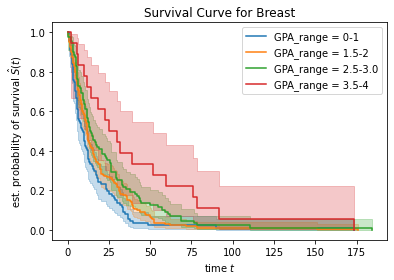

In [91]:
survival_curve_kmf(breast, gpa_range, site_name = 'Breast')

### Kidney survival curve

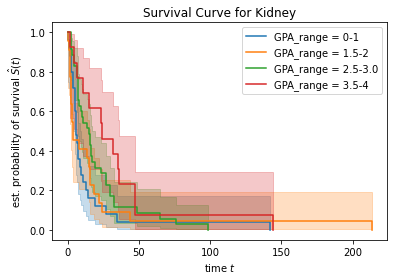

In [92]:
survival_curve_kmf(kidney, gpa_range, site_name = 'Kidney')

### Lung survival curve

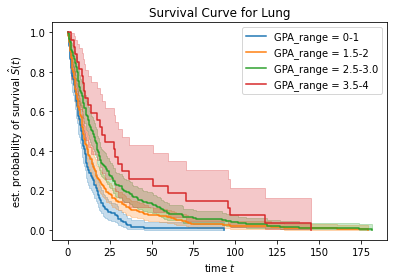

In [93]:
survival_curve_kmf(lung, gpa_range, site_name = 'Lung')

### Melanoma survival curve

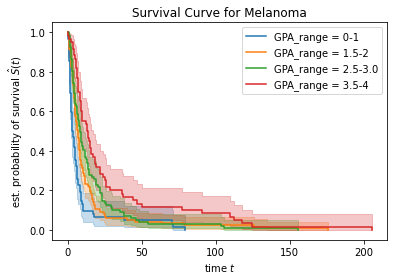

In [94]:
survival_curve_kmf(Melanoma, gpa_range, site_name = 'Melanoma')

In [95]:
### GI survival curve

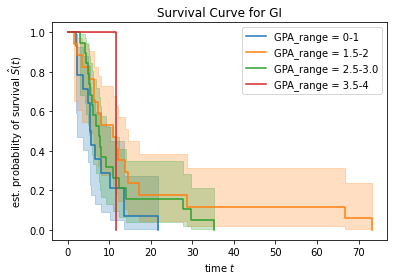

In [96]:
survival_curve_kmf(GI, gpa_range, site_name = 'GI')

# STEP 2

### Modelling part

#### Feature engineering

In [86]:
#### brain_mets is the original raw |data 

In [6]:
def label_encoding_with_NAs(train, col):
    train[col] = train[col].astype('category').cat.as_ordered()
    encoder = train[col].cat.categories
    # leaving 0 for NAs
    train[col] = train[col].cat.codes + 1
    #val[col] = pd.Categorical(val[col], categories=encoder, ordered=True)
    #val[col] = val[col].cat.codes + 1


#### Selecting 1st row

In [419]:
brain_mets['row_num'] = brain_mets.sort_values(['Patients','Date GK'], \
             ascending=[True,True])\
             .groupby(['Patients'])\
             .cumcount() + 1
modelling_data = brain_mets[brain_mets['row_num'] == 1]

In [420]:
modelling_data.drop(['PiCare MetID', 'Failure-binary', 
                      'Failure-eventFreeTime', 'row_num',
                      'Primary tumor Histology', 'Date GK', 'Patients'
                     ,'Lateral dimension', 'AP dimension', 'Vertical dimension','GPA',
                      'RPA','ECOG','Prescribed IDL', 'Target vol in IDL', 'Target vol in IDL', 'IDL volume',
                     'Vol in 12 Gy line', 'Vol in 10 Gy line', 'Conformity index',
                     'Gradient index', 'Heterogeneity index', 'Salvage_RS', 
                      'Salv_surg', 'Headaches', 'Seizures', 'Prescription Dose', 
                      'Max Dose', 'Target vol in IDL', 'Distance from Ventricle',
                     'BRAF_status', 'CKIT_status', 'NRAS_status', 'EFGR_status',
                      'ALK_status', 'HER2-amplified status', 'Distance_from_ventricle',
                     'Target vol in IDL.1'
                     ], axis = 1, inplace = True)

/Users/anishmukherjee/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [421]:
percent_missing = modelling_data.isnull().sum()/len(modelling_data)
missing_value_df = pd.DataFrame({'column_name': modelling_data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending = False)

,column_name,percent_missing
Race,Race,1.000000
Conc_Chemo,Conc_Chemo,0.840836
Brief location,Brief location,0.793676
Time to death,Time to death,0.224544
Neuro symptoms,Neuro symptoms,0.163987
Time between prim and met diagnosis,Time between prim and met diagnosis,0.161308
Prior_RS,Prior_RS,0.086817
Prior_EBRT,Prior_EBRT,0.053055
Maximum Tumor Diameter,Maximum Tumor Diameter,0.050375
Target volume,Target volume,0.042337


In [422]:
col_list = missing_value_df[missing_value_df['percent_missing'] < 0.40]['column_name'].values

In [423]:
col_list

array(['Follow-up time', 'Time to death', 'Age', 'Sex',
       'Primary tumor Site', 'ECM', 'Location', 'Side',
       '#Metastases at 1st GK', 'Time between prim and met diagnosis',
       'Prior SRS to same lesion', 'Prior SRS to other lesion',
       'KPS at 1st GK', 'Prior_EBRT', 'Prior_RS', 'Prior_Chemo',
       'Neuro symptoms', 'Target volume', 'Maximum Tumor Diameter'],
      dtype=object)

In [424]:
modelling_data = modelling_data[col_list]

In [425]:
### Label encoding non numeric columnms such as Sex

In [426]:
label_enc = modelling_data.iloc[:100,].applymap(np.isreal).all(0).values == False

In [427]:
label_enc_cols = list(modelling_data.iloc[:100,].applymap(np.isreal).all(0)[label_enc].index)

In [428]:
for i in label_enc_cols:
    if i != 'Primary tumor Site': 
        print(i)
        label_encoding_with_NAs(modelling_data, i)

Sex
ECM
Location
Side
Prior_RS
Prior_Chemo
Neuro symptoms


#### Preprocessing time of death

In [429]:
modelling_data['Time to death'] = np.where((modelling_data['Time to death'].isna()) & (
                                            modelling_data['Follow-up time'] > 0),
                                          modelling_data['Follow-up time'],
                                          modelling_data['Time to death'])
modelling_data.drop('Follow-up time' , axis = 1, inplace = True)
modelling_data['Time to death'] = modelling_data['Time to death']/30.5

In [430]:
### Dropping patient having null time of death

In [431]:
modelling_data = modelling_data[modelling_data['Time to death'].notnull()]

In [432]:
modelling_data.isnull().sum()

Time to death                            0
Age                                      0
Sex                                      0
Primary tumor Site                       0
ECM                                      0
Location                                 0
Side                                     0
#Metastases at 1st GK                    1
Time between prim and met diagnosis    238
Prior SRS to same lesion                 0
Prior SRS to other lesion                0
KPS at 1st GK                           47
Prior_EBRT                              47
Prior_RS                                 0
Prior_Chemo                              0
Neuro symptoms                           0
Target volume                           22
Maximum Tumor Diameter                  40
dtype: int64

#### filling null values by median

In [433]:
modelling_data.fillna(modelling_data.median(), inplace = True)

In [434]:
modelling_data.isnull().sum()

Time to death                          0
Age                                    0
Sex                                    0
Primary tumor Site                     0
ECM                                    0
Location                               0
Side                                   0
#Metastases at 1st GK                  0
Time between prim and met diagnosis    0
Prior SRS to same lesion               0
Prior SRS to other lesion              0
KPS at 1st GK                          0
Prior_EBRT                             0
Prior_RS                               0
Prior_Chemo                            0
Neuro symptoms                         0
Target volume                          0
Maximum Tumor Diameter                 0
dtype: int64

In [435]:
modelling_data['Primary tumor Site']

0            Lung
3            Lung
8        Melanoma
12       Melanoma
14           Lung
           ...   
10396        Lung
10410          GI
10425      Breast
10435    Melanoma
10443          GI
Name: Primary tumor Site, Length: 1579, dtype: object

In [436]:
# brain_mets_feat['Neuro symptoms'] = np.where(brain_mets_feat['Neuro symptoms'].isna(), -1, 
#                            np.where(brain_mets_feat['Neuro symptoms'] == 'True',1,0))
# brain_mets_feat['Side'] = np.where(brain_mets_feat['Side'].isna(), -1, 
#                            np.where(brain_mets_feat['Side'] == 'Right', 1,
#                            np.where(brain_mets_feat['Side'] == 'Left', 2, 3)))
# brain_mets_feat['Seizures'] = np.where((brain_mets_feat['Seizures'].isna() |
#                                        brain_mets_feat['Seizures'] == 'Unkn'), -1, 
#                               np.where(brain_mets_feat['Seizures'] == 'False', 0, 1))
# brain_mets_feat['Lateral dimension'].fillna(brain_mets_feat['Lateral dimension'].mean(), inplace = True)
# brain_mets_feat['AP dimension'].fillna(brain_mets_feat['AP dimension'].mean(), inplace = True)
# brain_mets_feat['Vertical dimension'].fillna(brain_mets_feat['Vertical dimension'].mean(), inplace = True)
# max_dia = brain_mets_feat[['Maximum Tumor Diameter','Patients']].groupby(by = 'Patients').max().reset_index()
# target_volume = brain_mets_feat[['Patients','Target volume']].groupby(by = 'Patients').sum().reset_index()
# ebrt = brain_mets_feat[['Patients','Prior_EBRT']].drop_duplicates()
# prior_rs = brain_mets_feat[['Patients','Prior_RS']].drop_duplicates()
# rest_ = brain_mets_feat[['Patients','Lateral dimension', 'Vertical dimension', 'AP dimension'
#                         ,'Seizures', 'Side', 'Neuro symptoms', 'Location']].drop_duplicates()

# modeling_dataset = final_dataset_gpa.drop(['Died', 'patient_gpa', 'gpa_range', 'row_num', 'Follow-up time', 'Date GK'], axis = 1)
# modeling_dataset['Time_to_death(months)'] = modeling_dataset['Time to death']/30.5
# modeling_dataset = modeling_dataset.merge(max_dia, on = ['Patients'], how = 'left')
# modeling_dataset = modeling_dataset.merge(target_volume, on = ['Patients'], how = 'left')
# modeling_dataset = modeling_dataset.merge(ebrt, on = ['Patients'], how = 'left')
# modeling_dataset = modeling_dataset.merge(prior_rs, on = ['Patients'], how = 'left')
# modeling_dataset['ECM'] = np.where(modeling_dataset['ECM'] == 0, 'False', modeling_dataset['ECM'])
# modeling_dataset = modeling_dataset.merge(rest_ , on = ['Patients'], how = 'left')
# modeling_dataset.drop(['Time to death','Patients'], axis = 1, inplace = True)

# a = modeling_dataset.iloc[:20,].applymap(np.isreal).all(0).values

# modeling_dataset.iloc[:20,].applymap(np.isreal).all(0)

# modeling_dataset['ECM'] = np.where(modeling_dataset['ECM'] == 'False', 0,  
#                                    np.where(modeling_dataset['ECM'] == 'True', 1 ,0.5))

# modeling_dataset['Sex'] = np.where(modeling_dataset['Sex'] == 'F', 0, 
#                                    np.where(modeling_dataset['Sex'] == 'M', 1 ,0.5))

# modeling_dataset['Prior_RS'] = np.where(modeling_dataset['Prior_RS'] == 'False', 0, 
#                                    np.where(modeling_dataset['Prior_RS'] == 'True', 1 ,0.5))   

# modeling_dataset['Prior_EBRT'] = np.where(modeling_dataset['Prior_EBRT'] == 'False', 0, 1)   



In [437]:
### Melanoma
modelling_data.describe()

,Time to death,Age,Sex,ECM,Location,Side,#Metastases at 1st GK,Time between prim and met diagnosis,Prior SRS to same lesion,Prior SRS to other lesion,KPS at 1st GK,Prior_RS,Prior_Chemo,Neuro symptoms,Target volume,Maximum Tumor Diameter
count,1579.000000,1579.000000,1579.000000,1579.000000,1579.000000,1579.000000,1579.000000,1579.000000,1579.0,1579.000000,1579.000000,1579.000000,1579.000000,1579.000000,1579.000000,1579.000000
mean,18.241552,57.661381,2.412920,2.688410,20.368588,2.011400,3.893604,1409.878404,0.0,0.008866,81.304623,0.975934,2.028499,1.333756,3.330314,1.855326
std,26.368699,12.508066,0.495081,0.532051,11.473491,1.004361,4.131560,3160.857809,0.0,0.093773,10.624137,0.327340,0.625664,0.738713,4.565908,0.975811
min,0.032787,7.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000,40.000000,0.000000,1.000000,0.000000,0.011000,0.300000
25%,4.491803,49.446575,2.000000,2.000000,10.000000,1.000000,1.000000,338.000000,0.0,0.000000,80.000000,1.000000,2.000000,1.000000,0.320500,1.100000
50%,9.311475,58.134247,2.000000,3.000000,16.000000,2.000000,3.000000,750.000000,0.0,0.000000,80.000000,1.000000,2.000000,1.000000,1.450000,1.700000
75%,19.770492,66.278082,3.000000,3.000000,30.000000,3.000000,5.000000,1492.000000,0.0,0.000000,90.000000,1.000000,2.000000,2.000000,4.595000,2.400000
max,213.672131,97.810959,3.000000,4.000000,45.000000,3.000000,61.000000,42556.000000,0.0,1.000000,100.000000,3.000000,4.000000,3.000000,36.100000,9.000000


In [438]:
modelling_data.columns

Index(['Time to death', 'Age', 'Sex', 'Primary tumor Site', 'ECM', 'Location',
       'Side', '#Metastases at 1st GK', 'Time between prim and met diagnosis',
       'Prior SRS to same lesion', 'Prior SRS to other lesion',
       'KPS at 1st GK', 'Prior_EBRT', 'Prior_RS', 'Prior_Chemo',
       'Neuro symptoms', 'Target volume', 'Maximum Tumor Diameter'],
      dtype='object')

## Melanoma 

In [171]:
best_model_melanoma = []

In [42]:
## Controlling the decsion trees hyperparameters
from random import sample
def get_random_hyper():
    min_samples_leaf = np.random.randint(low = 4, high =80, size=1)[0]
    # max_leaf_nodes = np.random.randint(low = 1, high = leaves, size=1)[0]
    max_features = sample(['auto','sqrt','log2'],1)
    return min_samples_leaf,max_features[0]

In [70]:
def pick_best_model(modelling_data, indication, iterations, max_leaf_nodes):
    y = modelling_data[modelling_data['Primary tumor Site'] == indication]['Time to death']
    x = modelling_data[modelling_data['Primary tumor Site'] == indication].drop(['Time to death','Primary tumor Site'],axis =1)
    x.reset_index(inplace = True)
    x.drop('index', inplace = True, axis = 1)
    y.reset_index(inplace = True, drop = True)
    max_rsquared = -100
    y_test_total = []
    ## iterating over the decision tree hyperparameters and picking the best
    kf = KFold(n_splits = 10)
    kf.get_n_splits(x)
    y_pred = []
    for i in range(0,iterations):
        min_samples_leaf,max_features = get_random_hyper()
        for train_index, test_index in kf.split(x):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index] 
            y_train, y_test = y[train_index], y[test_index]
            dt = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes,
                                       min_samples_leaf = min_samples_leaf, 
                                       max_features = max_features)
            dt.fit(x_train, y_train)
            y_pred.append(dt.predict(x_test))
            y_test_total.append(y_test)
        r_squared = r2_score(np.concatenate(y_test_total), np.concatenate(y_pred))
        if r_squared > max_rsquared:
            max_rsquared = r_squared
            best_model = dt
    return max_rsquared, best_model        

In [183]:
def survival_curve_and_ci(best_model,modelling_data, indication):
    y = modelling_data[modelling_data['Primary tumor Site'] == indication]['Time to death']
    x = modelling_data[modelling_data['Primary tumor Site'] == indication].drop(['Time to death','Primary tumor Site'],axis =1)
    x.reset_index(inplace = True)
    x.drop('index', inplace = True, axis = 1)
    y.reset_index(inplace = True, drop = True)
    prediction = best_model.predict(x)
    prediction = pd.Series(prediction)
    df = pd.concat([y,prediction],axis = 1)
    df.rename(columns = {0: 'prediction'}, inplace = True)
    a = list(df['prediction'].unique())
    a.sort()
    df['New_GPA'] = df['prediction'].map(lambda x: a.index(x))
    df['Died'] = True
    df.drop('prediction', axis  = 1, inplace = True)
    gpa_range = list(df['New_GPA'].unique())
    gpa_range.sort()
    survival_curve_kmf(df, gpa_range, site_name = indication, 
                   classes = "New_GPA", survival_col = "Died",time_col = "Time to death")
    df['Primary tumor Site'] = indication
    df.rename(columns  = {'Time to death': 'months', 'New_GPA': 'gpa_range'}, inplace = True)
    df_ci = CI(df)
    return df_ci
    

In [154]:
def tree_plot(best_model, modelling_data, indication):
    y = modelling_data[modelling_data['Primary tumor Site'] == indication]['Time to death']
    x = modelling_data[modelling_data['Primary tumor Site'] == indication].drop(['Time to death','Primary tumor Site'],axis =1)
    x.reset_index(inplace = True)
    x.drop('index', inplace = True, axis = 1)
    y.reset_index(inplace = True, drop = True)
    viz = dtreeviz(best_model, x, y,
                target_name="survival_length",
                feature_names=x.columns)
    return viz

### 2 leaves

In [167]:
rsquared, best_model = pick_best_model(modelling_data, 'Melanoma', iterations = 25, max_leaf_nodes = 2 )

In [168]:
best_model

DecisionTreeRegressor(max_features='log2', max_leaf_nodes=2,
                      min_samples_leaf=77)

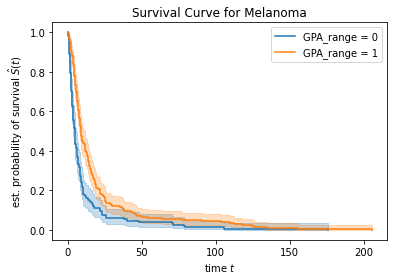

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,4.622951,3.672131,5.409836
0.5,Melanoma,1,8.885246,7.639344,11.475410


In [169]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Melanoma')

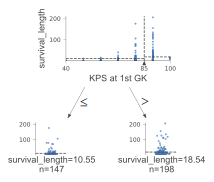

In [170]:
tree_plot(best_model,modelling_data, 'Melanoma')

In [172]:
best_model_melanoma.append(best_model)

### 3 leaves

In [180]:
rsquared, best_model = pick_best_model(modelling_data, 'Melanoma', iterations = 25, max_leaf_nodes = 3 )

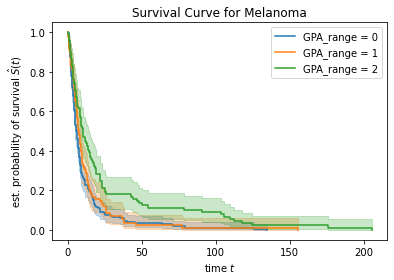

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,6.000000,4.918033,7.180328
0.5,Melanoma,1,7.606557,6.196721,9.377049
0.5,Melanoma,2,10.590164,8.163934,14.590164


In [184]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Melanoma')

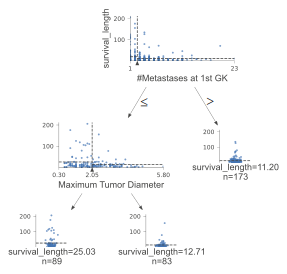

In [185]:
tree_plot(best_model,modelling_data, 'Melanoma')

In [186]:
best_model_melanoma.append(best_model)

### 4 Leaves

In [260]:
rsquared, best_model = pick_best_model(modelling_data, 'Melanoma', iterations = 25, max_leaf_nodes = 4 )


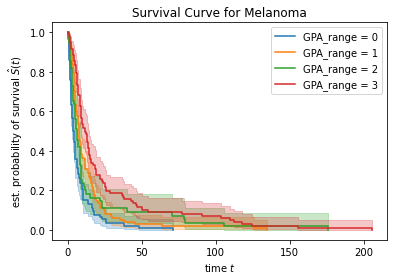

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,3.901639,2.852459,4.688525
0.5,Melanoma,1,7.409836,6.000000,8.754098
0.5,Melanoma,2,6.262295,4.163934,8.393443
0.5,Melanoma,3,11.475410,8.885246,14.590164


In [261]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Melanoma')

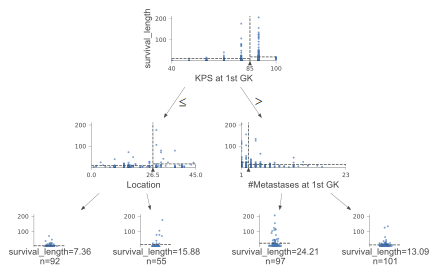

In [262]:
tree_plot(best_model,modelling_data, 'Melanoma')

In [263]:
best_model_melanoma.append(best_model)

In [264]:
best_model_melanoma

[DecisionTreeRegressor(max_features='log2', max_leaf_nodes=2,
                       min_samples_leaf=77),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=3,
                       min_samples_leaf=35),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=4,
                       min_samples_leaf=42)]

## LUNG

In [269]:
best_model_lung = []

### 2 Leaves

In [267]:
rsquared, best_model = pick_best_model(modelling_data, 'Lung', iterations = 25, max_leaf_nodes = 2 )


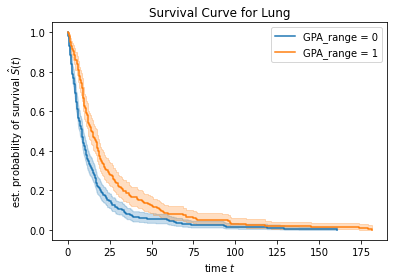

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Lung,0,8.360656,7.049180,9.180328
0.5,Lung,1,14.360656,11.967213,17.311475


In [268]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Lung')

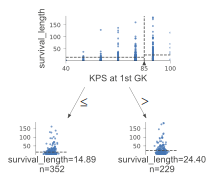

In [270]:
tree_plot(best_model,modelling_data, 'Lung')

In [271]:
best_model_lung.append(best_model)

### 3 Leaves

In [312]:
rsquared, best_model = pick_best_model(modelling_data, 'Lung', iterations = 25, max_leaf_nodes = 3 )

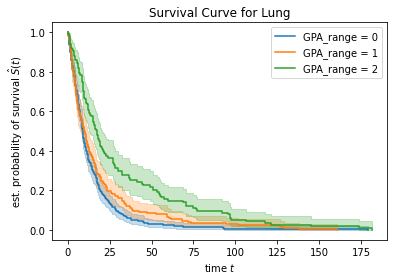

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Lung,0,8.885246,8.098361,9.901639
0.5,Lung,1,10.065574,7.442623,11.901639
0.5,Lung,2,17.278689,12.754098,20.426230


In [313]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Lung')

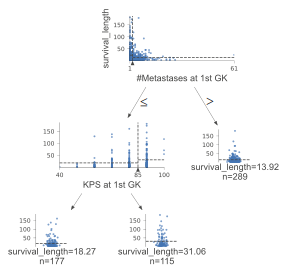

In [314]:
tree_plot(best_model,modelling_data, 'Lung')

In [316]:
best_model_lung.append(best_model)

In [2]:
best_model_lung

NameError: name 'best_model_lung' is not defined

### 4 Leaves

In [347]:
squared, best_model = pick_best_model(modelling_data, 'Lung', iterations = 25, max_leaf_nodes = 4 )

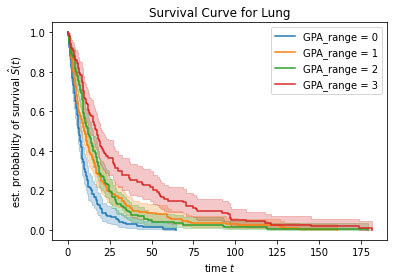

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Lung,0,6.622951,5.836066,8.098361
0.5,Lung,1,10.065574,7.442623,11.901639
0.5,Lung,2,12.000000,9.508197,14.885246
0.5,Lung,3,17.278689,12.754098,20.426230


In [348]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Lung')

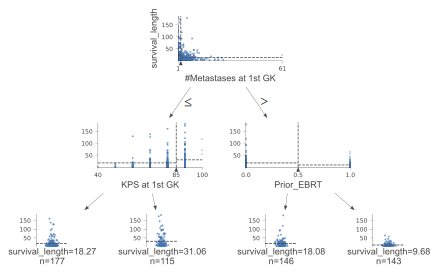

In [349]:
tree_plot(best_model,modelling_data, 'Lung')

In [350]:
best_model_lung.append(best_model)

## BREAST

In [377]:
best_model_breast = []

### 2 Leaves

In [374]:
rsquared, best_model = pick_best_model(modelling_data, 'Breast', iterations = 25, max_leaf_nodes = 2 )

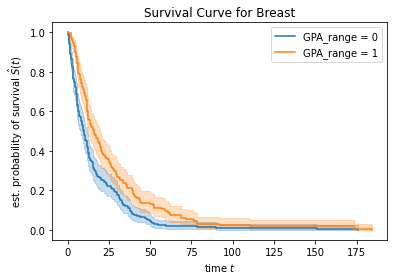

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Breast,0,9.704918,7.770492,11.803279
0.5,Breast,1,15.704918,12.393443,19.672131


In [375]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Breast')

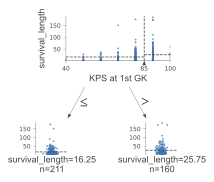

In [376]:
tree_plot(best_model,modelling_data, 'Breast')

In [378]:
best_model_breast.append(best_model)

### 3 Leaves

In [395]:
rsquared, best_model = pick_best_model(modelling_data, 'Breast', iterations = 25, max_leaf_nodes = 3 )

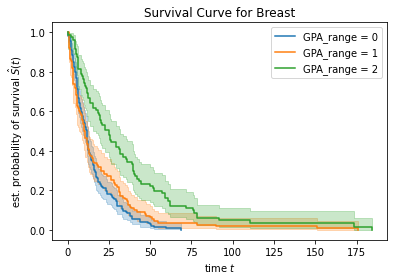

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Breast,0,11.409836,9.081967,12.196721
0.5,Breast,1,10.032787,7.770492,12.590164
0.5,Breast,2,24.950820,17.114754,31.639344


In [396]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Breast')

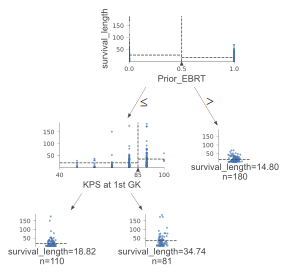

In [397]:
tree_plot(best_model,modelling_data, 'Breast')

In [398]:
best_model_breast.append(best_model)

### 4 Leaves

In [407]:
rsquared, best_model = pick_best_model(modelling_data, 'Breast', iterations = 25, max_leaf_nodes = 4)


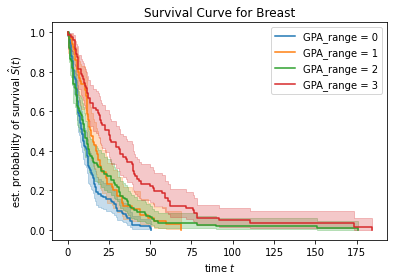

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Breast,0,8.950820,6.491803,11.377049
0.5,Breast,1,14.327869,11.672131,18.262295
0.5,Breast,2,10.032787,7.770492,12.590164
0.5,Breast,3,24.950820,17.114754,31.639344


In [408]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Breast')

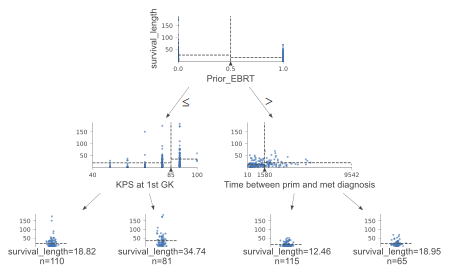

In [409]:
tree_plot(best_model,modelling_data, 'Breast')

In [410]:
best_model_breast.append(best_model)

## Kidney

In [466]:
best_model_kidney = []

### 2 Leaves

In [462]:
rsquared, best_model = pick_best_model(modelling_data, 'Kidney', iterations = 350, max_leaf_nodes = 2 )

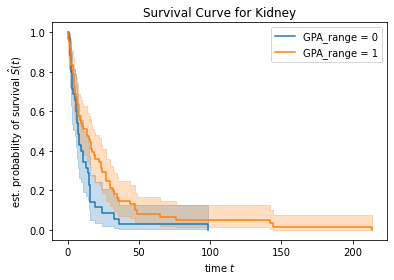

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Kidney,0,7.508197,5.442623,11.081967
0.5,Kidney,1,13.540984,7.081967,18.721311


In [463]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Kidney')

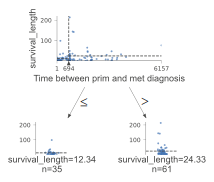

In [465]:
tree_plot(best_model,modelling_data, 'Kidney')

In [467]:
best_model_kidney.append(best_model)

### 3 Leaves

In [598]:
rsquared, best_model = pick_best_model(modelling_data, 'Kidney', iterations = 25, max_leaf_nodes = 3)

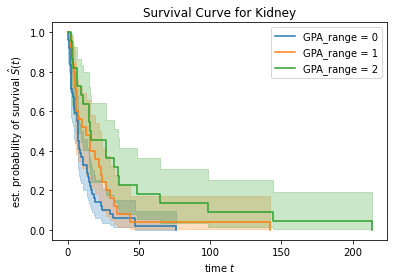

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Kidney,0,7.180328,4.459016,9.213115
0.5,Kidney,1,12.655738,5.540984,23.475410
0.5,Kidney,2,15.344262,6.688525,35.442623


In [599]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Kidney')

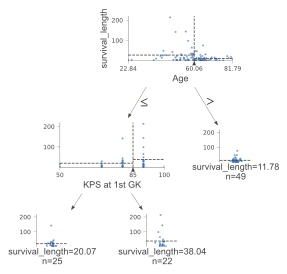

In [600]:
tree_plot(best_model,modelling_data, 'Kidney')

In [525]:
best_model_kidney.append(best_model)

### 4 Leaves

In [546]:
rsquared, best_model = pick_best_model(modelling_data, 'Kidney', iterations = 25, max_leaf_nodes = 4)

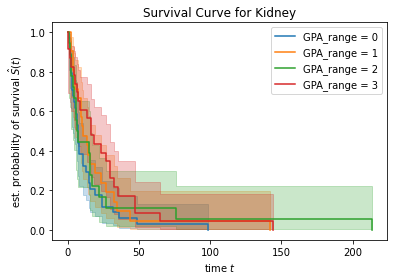

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Kidney,0,7.081967,3.475410,11.081967
0.5,Kidney,1,10.918033,5.311475,19.245902
0.5,Kidney,2,7.344262,3.639344,15.934426
0.5,Kidney,3,16.721311,6.688525,29.508197


In [547]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Kidney')

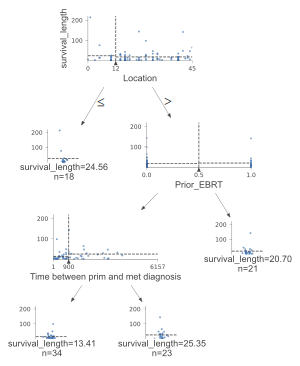

In [548]:
tree_plot(best_model,modelling_data, 'Kidney')

In [549]:
best_model_kidney.append(best_model)

### Step 3

In [1616]:
from sklearn.ensemble import RandomForestRegressor
def get_random_hyper():
    min_samples_leaf = np.random.randint(low = 4, high = 80, size=1)[0]
    max_depth = np.random.randint(low = 1, high = 5, size=1)[0]
    max_features = sample(['sqrt','log2'],1)
    return min_samples_leaf,max_depth,max_features[0]

In [1648]:
y = modelling_dataset[modelling_dataset['Primary tumor Site'] == 'Melanoma']['Time to death']
x = modelling_dataset[modelling_dataset['Primary tumor Site'] == 'Melanoma'].drop(['Time to death','Primary tumor Site'],axis =1)
x.reset_index(inplace = True)
x.drop('index', inplace = True, axis =1)
y.reset_index(inplace = True, drop = True)
max_rsquared = -100
y_test_total = []
## iterating over the decision tree hyperparameters and picking the best
kf = KFold(n_splits = 10)
kf.get_n_splits(x)
y_pred = []
for i in range(0,100):
    min_samples_leaf, max_depth,max_features = get_random_hyper()
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        rf = RandomForestRegressor(max_depth = max_depth, 
                                   min_samples_leaf = min_samples_leaf, max_features = 'log2',
                                  n_estimators = 300)
        rf.fit(x_train, y_train)
        y_pred.append(dt.predict(x_test))
        y_test_total.append(y_test)
    r_squared = r2_score(np.concatenate(y_test_total), np.concatenate(y_pred))
    if r_squared > max_rsquared:
        max_rsquared = r_squared
        best_model = dt    
    
#dt.score(y_train.values.reshape(-1,1),y_pred.reshape(-1,1))

In [1642]:
prediction = best_model.predict(x)
prediction = pd.Series(prediction)
melanoma = pd.concat([y,prediction],axis = 1)
melanoma.rename(columns = {0: 'prediction'}, inplace = True)
a = list(melanoma['prediction'].unique())
a.sort()
melanoma['New_GPA'] = melanoma['prediction'].map(lambda x: a.index(x))
melanoma['Died'] = True
melanoma.drop('prediction', axis  = 1, inplace = True)
gpa_range = list(melanoma['New_GPA'].unique())
gpa_range.sort()

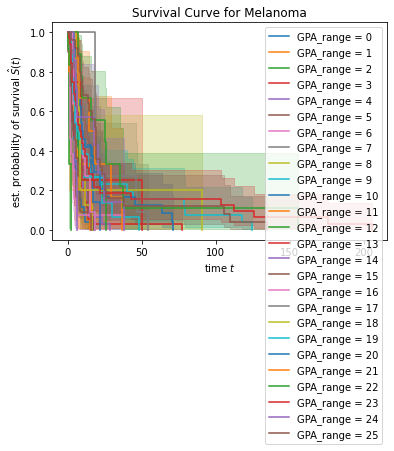

In [1639]:
survival_curve_kmf(melanoma, gpa_range, site_name = 'Melanoma', 
                   classes = "New_GPA", survival_col = "Died",time_col = "Time to death")

In [1647]:
prediction.value_counts()

21.809895    1
9.747496     1
10.350591    1
16.974556    1
16.013766    1
            ..
16.607534    1
16.498315    1
10.682225    1
20.011387    1
10.625013    1
Length: 345, dtype: int64

In [1649]:
max_rsquared

0.10772615246940476

In [1]:
from scipy.stats import median_test